In [2]:
import MDAnalysis as mda
from numpy import *
import os
from pylab import *
import MDAnalysis.analysis.distances
import MDAnalysis.analysis.rms
from MDAnalysis.analysis import align
import glob
#import umap
import scipy.stats
import sklearn
import sklearn.decomposition
import sklearn.preprocessing
import mdtraj
import pandas as pd
import seaborn as sns
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [3]:
EQPOINT=250



h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=sorted(glob.glob(h2opath+"*.gro"))
peggros=sorted(glob.glob(pegpath+"*.gro"))

#glob tprs
h2otprs=sorted(glob.glob(h2opath+"*.tpr"))
pegtprs=sorted(glob.glob(pegpath+"*.tpr"))

#trjs
h2otrjs=sorted(glob.glob(h2opath+"*.xtc"))
pegtrjs=sorted(glob.glob(pegpath+"*.xtc"))

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))
#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2otprs[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(pegtprs[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper

#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#0A732D","#332288"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]

In [4]:
import numpy as np

def contact_size(system):
    '''The function calculates the size of the vector needed to contain contact map '''
    counter = 0
    for res1 in system.residues:
        for res2 in system.residues:
            if abs(res1.resid - res2.resid) > 1 and res1.resid < res2.resid:
                counter += 1
    return counter
def contact_map2(system, stride,sel="not name H*",cutoff = 4.5):
    ''' Faster!!! The function creates contact map (0 and 1) for for every pair of aminoacids'''
    sel_heavy = sel
    num_data_points = (len(system.trajectory) // stride) + (0 if (len(system.trajectory) % stride == 0) else 1)
    size = contact_size(system.select_atoms(sel))
    contacts = np.empty((num_data_points, size), dtype=np.float)
    slices = []
    min_i = 0
    max_i = 0
    for res in system.select_atoms(sel).residues:
        max_i = min_i + res.atoms.select_atoms(sel_heavy).n_atoms
        slices.append((min_i, max_i))
        min_i = max_i

    #print(slices)
    heavy_system = system.select_atoms(sel_heavy)
    index = 0
    for ts in system.trajectory[::stride]:
        if ts.frame % 100 == 0 :
            output = round(100 * ts.frame / len(system.trajectory), 1)
            print(output,"% complete",end='\r')
            sys.stdout.flush()
        contact_map = np.zeros(size, dtype=np.float)
        contact_matrix = MDAnalysis.analysis.distances.contact_matrix(heavy_system.atoms.positions, cutoff = cutoff)
        counter = 0
        for i, res1 in enumerate(slices):
            i1 = res1[0]
            i2 = res1[1]
            for j, res2 in enumerate(slices):
                if abs(i - j) > 1 and i < j:
                    j1 = res2[0]
                    j2 = res2[1]
                    if np.any(contact_matrix[i1:i2, j1:j2]):
                        contact_map[counter] = 1.
                    counter += 1
        contacts[index,:] = contact_map
        index += 1
    return contacts


def getContacts(systems,datasets,selection_strings,stride=10,EQPOINT=250,cutoff = 5.5):
    
    contacts=[]
    stderrs=[]
    allcontacts=[]
    for i in range(len(datasets)):
        subcontacts=[]
        for j in range(len(datasets[i])):
            cont = contact_map2(systems[i][j],stride,sel = selection_strings[i][j],cutoff = cutoff)
            subcontacts.append(mean(cont,axis=0))
            #print(cont.shape)
        print(subcontacts)
        #contacts.append(mean(mean(subcontacts,axis = 0)[EQPOINT:],axis=0))
        allcontacts.append(subcontacts)
    
    return allcontacts

allcontacts=getContacts(systems,fullprotein_selections,fullprotein_selections_string,stride = 1,EQPOINT=EQPOINT,cutoff = 3.5)# let's jsut mean along time as well

/tmp/ipykernel_2020212/3158721905.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  contacts = np.empty((num_data_points, size), dtype=np.float)
/tmp/ipykernel_2020212/3158721905.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  contact_map = np.zeros(size, dtype=np.float)


[array([0.47652348, 0.07992008, 0.01898102, ..., 0.23176823, 0.64335664,
       0.        ]), array([0.41858142, 0.03896104, 0.08391608, ..., 0.14085914, 0.62837163,
       0.        ]), array([0.37362637, 0.03996004, 0.00599401, ..., 0.18181818, 0.52547453,
       0.        ]), array([0.35764236, 0.05794206, 0.004995  , ..., 0.24175824, 0.57442557,
       0.        ]), array([0.43656344, 0.08391608, 0.01498501, ..., 0.13486513, 0.57642358,
       0.        ])]
[array([0.3976024 , 0.01698302, 0.        , ..., 0.25174825, 0.67532468,
       0.        ]), array([0.28971029, 0.01398601, 0.        , ..., 0.35164835, 0.67832168,
       0.        ]), array([0.35764236, 0.00599401, 0.        , ..., 0.19080919, 0.63636364,
       0.        ]), array([0.29370629, 0.01198801, 0.        , ..., 0.18781219, 0.56343656,
       0.        ]), array([0.34265734, 0.004995  , 0.        , ..., 0.10989011, 0.63536464,
       0.        ])]


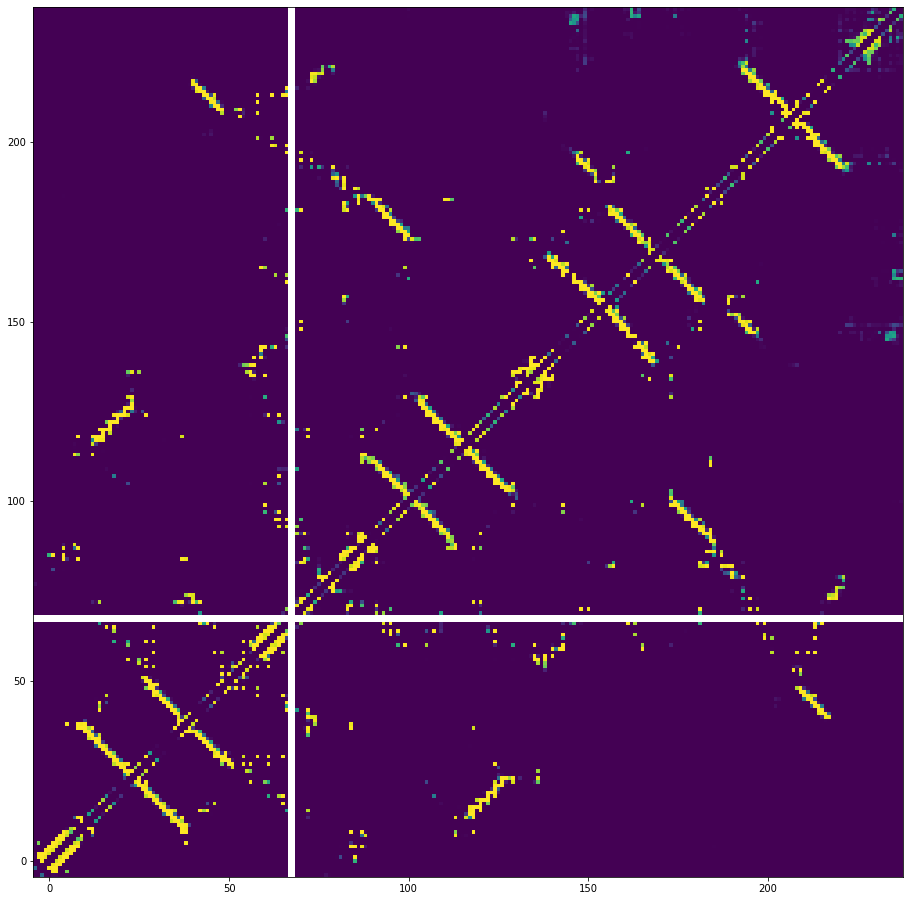

In [7]:
def BestTwoD(array1d):
    #The number of dimensions (excluding nearest neighbours and self)
    N = int(1.5 + .5*np.sqrt(1+(8*len(array1d))))

    #Construct a 2D version of the contact map (it excludes nearesty neighbours and self, but there are still NxN slots)
    twoD=zeros((N,N))            
    j=2
    k=0
    for i in range(len(array1d)):
        if abs(j-k)>1:
            twoD[j][k] = array1d[i]
            twoD[k][j] = array1d[i]
        j+=1
        if j == len(twoD):
            k+=1
            j = k+2
            if k==len(twoD)-2 and j >len(twoD)-2 :
                break
    return twoD


allTwoD=[]

for syst in range(len(allcontacts)):
    sub=[]
    for trjnum in range(len(allcontacts[syst])):
        # Assign the current trajectory
        tac=allcontacts[syst][trjnum]
        # Select protein atoms
        p=systems[0][0].select_atoms("protein or resname CH6")

        #Make a dictionary that maps the "resid" to an index from 0 to Nresidues-1
        resid_index_map=dict(zip(p.residues.resids,arange(len(p.residues.resids))))


        twoD = BestTwoD(tac)


        # Next, we want a 2D map that also leaves NANs in the places where there are non-exiseting resids, so taht contacts aren't off by 2 
        # (since the chromophore counts as 1 residue but takes up 3 resids basically)          

        # Creatge an array of NANs, with the shape of the final array (which in this case should be arange(resid[0],resid[-1]+1))
        # Then it loops through a list of the indices that should have a non-NAN value, and puts in the correct value.
        # Ok we can apply that to this situation as well.

        totalMap=ones((len(arange(resids_proper[0],resids_proper[-1]+1)),len(arange(resids_proper[0],resids_proper[-1]+1))))*nan

        extantIndices = p.residues.resids-p.residues.resids[0]

        for i in range(len(extantIndices)):
            for j in range(len(extantIndices)):

                totalMap[extantIndices[i]][extantIndices[j]]=copy(twoD[i,j])
        sub.append(totalMap)
    allTwoD.append(sub)
        

figure(figsize = (16,16))      
imshow(totalMap,origin = "lower",extent = (resids_proper[0]-0.5,resids_proper[-1]+0.5,resids_proper[0]-0.5,resids_proper[-1]+0.5))


(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

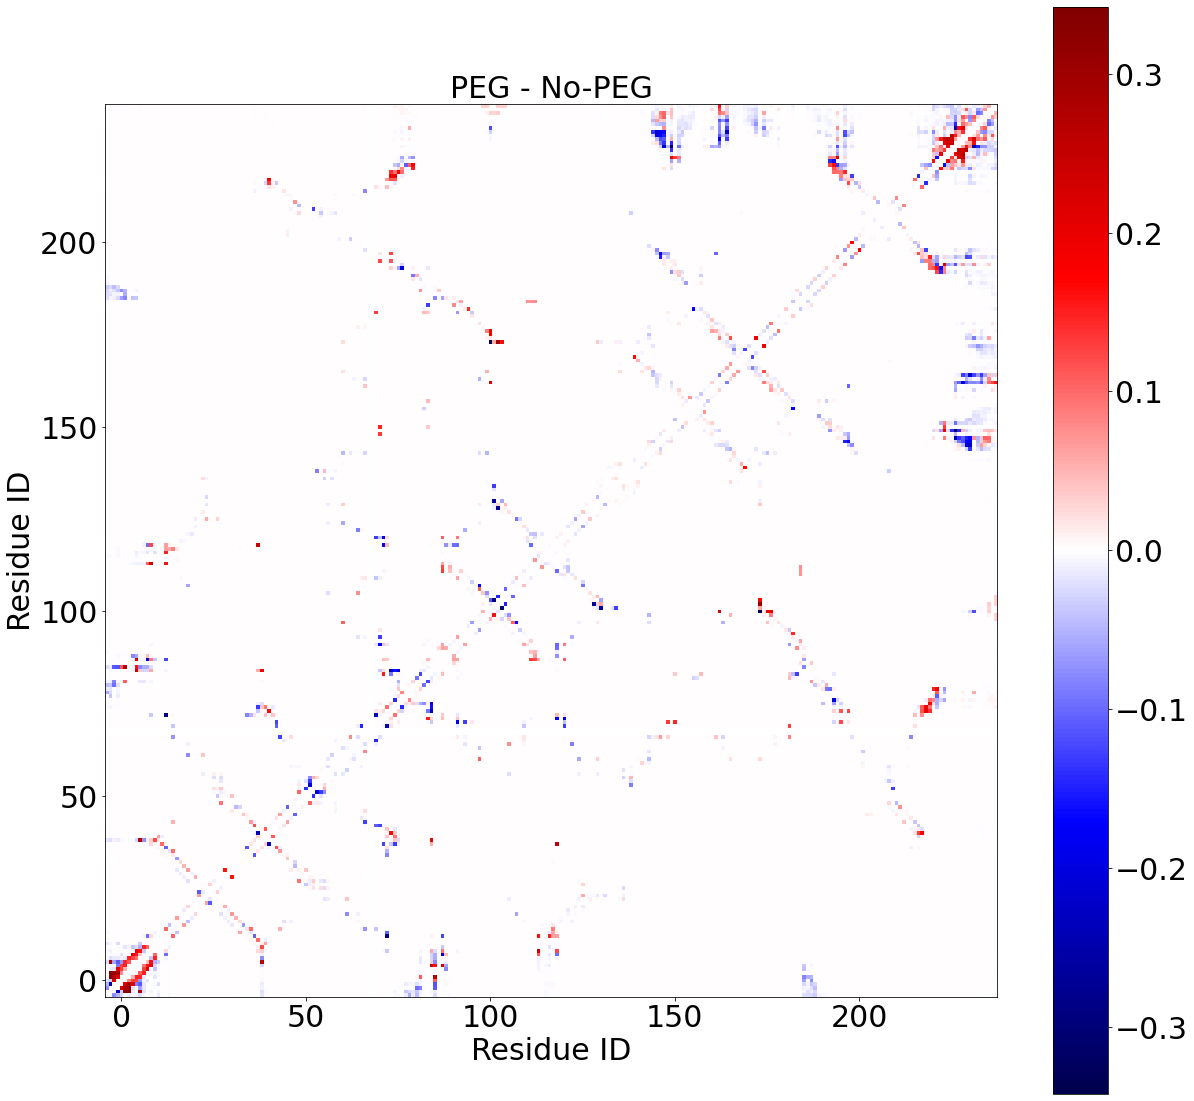

In [19]:
allTwoD_avg_systems=[]
allTwoD_sem_systems=[]
for i in range(len(systems)):
    
    allTwoD_avg_systems.append(mean(allTwoD[i],axis = 0))
    allTwoD_sem_systems.append(scipy.stats.sem(allTwoD[i],axis = 0))

    
diffmap = allTwoD_avg_systems[1] - allTwoD_avg_systems[0]
semDiffBars = sqrt(allTwoD_sem_systems[1]**2 + allTwoD_sem_systems[0]**2)

significant_diffbars=copy(diffmap)
for i in range(len(diffmap)):
    for j in range(len(diffmap[i])):

        
        if abs(semDiffBars[i][j]) > abs(diffmap[i][j]):
            significant_diffbars[i][j] = 0
            semDiffBars[i] = 0

drange = max(abs(simple_diffmap[15:220]).flatten())

figure(figsize = (20,20))
imshow(significant_diffbars,origin = "lower",cmap='seismic',vmin=-drange,vmax=drange,extent = (resids_proper[0]-0.5,resids_proper[-1]+0.5,resids_proper[0]-0.5,resids_proper[-1]+0.5))

#5.55.55.5
cbar=colorbar()
cbar.ax.tick_params(labelsize=30) 
xlabel("Residue ID",fontsize = 30)
ylabel("Residue ID",fontsize = 30)
title(system_names[1] + " - " + system_names[0],fontsize = 30)
xticks(fontsize = 30)
yticks(fontsize = 30)
#axhline(164)

#axvline(66)


In [20]:
save("fullContactDifferenceMap.npy",significant_diffbars)

In [27]:
len(systems[0][0].select_atoms("protein or resname CH6").residues)

240